In [1]:
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from seaborn_analyzer import CustomPairPlot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from sklearn.feature_selection import VarianceThreshold

from tqdm import tqdm
from IPython.display import HTML


import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 2000)


# 再現性をもたせるためのseed固定
SEED = config.SEED

In [2]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

# 各遺伝子データの読み込み

In [3]:
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T

df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
)

df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
)

df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop("Entrez_Gene_Id")

# 　ファイルの中身が壊れているため、使用するなら要修正
# df_mutations = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_mutations.txt").T


# 各dfの中身変更防止の為setを仕様
df_set = (
    df_cna,
    df_methylation_promoters_rrbs,
    df_mrna_agilent_microarray_zscores_ref_all_samples,
    df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    df_mrna_agilent_microarray,
    # df_mutations
)
df_name_set = (
    "df_cna",
    "df_methylation_promoters_rrbs",
    "df_mrna_agilent_microarray_zscores_ref_all_samples",
    "df_mrna_agilent_microarray",
    # "df_mutations"
)

## indexと対応させるために読み込み

### 目的変数の生成

元のdfにはない目的変数カラム（5年後の生存の有無）を生成する。

#### 目的変数｜5年後の予後の2値分類
5年後の予後を2値分類する。  
そのためにVITAL_STATUSとOS_MONTHを利用する。  
以下のフローチャートで生成する。  

In [4]:
HTML(
    '<div class="mxgraph" style="max-width:100%;border:1px solid transparent;" data-mxgraph="{&quot;highlight&quot;:&quot;#0000ff&quot;,&quot;nav&quot;:true,&quot;resize&quot;:true,&quot;toolbar&quot;:&quot;zoom layers tags lightbox&quot;,&quot;edit&quot;:&quot;_blank&quot;,&quot;xml&quot;:&quot;&lt;mxfile host=\&quot;Electron\&quot; modified=\&quot;2022-05-01T07:33:42.0.405Z\&quot; agent=\&quot;5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) draw.io/17.2.0.2 Chrome/100.0.4896.60 Electron/18.0.1 Safari/537.36\&quot; etag=\&quot;CUa6MuG2A-EYqdbBh0ys\&quot; version=\&quot;17.2.0.2\&quot; type=\&quot;device\&quot;&gt;&lt;diagram id=\&quot;C5RBs43oDa-KdzZeNtuy\&quot; name=\&quot;Page-1\&quot;&gt;7VhZc5swEP41TJ7a4Yix/RjbcZI2SduBJNOnjAIyqBasK4SP/vpKQTIQXB9tncMTP3jYZVlJ+317gOH0k/kZQ5P4CkJMDdsM54YzMGy7ZZniXyoWhcLtOoUiYiQsVFap8MgvrJTquSgnIc5qhhyAcjKpKwNIUxzwmg4xBrO62QhofdUJinBD4QWINrV3JORxoe3Y7VJ/jkkU65Utt1vcSZA2VifJYhTCrKJyTg2nzwB4cZXM+5jK2Om43F0s7ujl2D379C37iW56n/3r2w+Fs+EujyyPwHDK/69ru3A9RTRX8VJn5QsdQAZ5GmLpxDScXswTKi4tcfkDc75QgKOcg1AB4zFEkCJ6CTBRdiNIuTKzpIzT8EQCK+QHCsG4UA0JpWoNISn7jpAyzmC8xE46WAIhjSl6wLSHgnH0uNE+UGDiVgoplq5CQQZ1lnJzp6W2t2VsFQYZ5CzAa+xUcnDEIrzOn1vYyf1VeKqQO8OQYM4WwoBhijiZ1smMVE5ES7sSd3GhoN+BBk6DBuHIaPVuL/yTy3vPP/FvPMMWrs0v3v3Vl2v/3DNagzVMkSjNYsKxN0GP4ZqJ2lJnT5UV4uC9iKIsU5hugHw3yKaYcTxfG2R911WZrkpdR4mzsm5YuhjElZpxbO4JluMGLN9FKX1P0H9JUHfLBNX9a2OGKrJoYmydsMrTVyDiXKUJjEaZ2NhT6iwX/Hs2tRpsuoYGmTbj8abp9kJkau/GJevVc8ltcKnsDDITXJTIek+5jLm8b+raWi1cMSQPeba5V9QAlvQZooRQGaxzTKeYkwCt6CiIkigVQiCwxmw1c8SSJI2E5JaS/8hUUXz32Gna9U6zlKutxlzRajr7ajXt1ROAYrZs9maB4xDRDB9c63fsJ4B0X7r3d7ap1m+6Fj9769dldXPvt7as14o95kdH/GoEev3jQHer4fJ9HtgPw+xDmwj0Dit8qr8+qv5xNCCCLLYJI/E3IBlGGT56Hw3+OBrYqzrRs44GuhpWZwMmAnFoM8DT1/9j56VnAF0lNk9lPssPfyhzrP0BIsTyS25RE8vP4c7pbw==&lt;/diagram&gt;&lt;/mxfile&gt;&quot;}"></div><script type="text/javascript" src="https://viewer.diagrams.net/js/viewer-static.min.js"></script>'
)

In [5]:
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")

df_MB["target_OS_5years"] = np.nan
df_MB["target_OS_5years"] = df_MB["target_OS_5years"].mask(
    df_MB["OS_MONTHS"] > 60, False
)
df_MB["target_OS_5years"] = df_MB["target_OS_5years"].mask(
    (df_MB["OS_MONTHS"] <= 60) & (df_MB["VITAL_STATUS"] == "Died of Disease"),
    True,
)
df_MB["target_OS_5years"] = df_MB["target_OS_5years"].astype(bool)
# targetを定義できなかったデータは除く
# df_MB = df_MB[df_MB["target_OS_5years"].notnull()]

# 治療クラスの値変更
df_MB["HORMONE_THERAPY"].replace({"YES": 1, "NO": 0}, inplace=True)
df_MB["RADIO_THERAPY"].replace({"YES": 1, "NO": 0}, inplace=True)
df_MB["BREAST_SURGERY"].replace({"BREAST CONSERVING": 1, "MASTECTOMY": 0}, inplace=True)

# 目的変数生成で使用した特徴量を削除
df_MB.drop(["OS_MONTHS", "OS_STATUS", "VITAL_STATUS"], axis=1, inplace=True)

# df_mrna_agilent_microarrayを使用して前処理を実施

### df_MBの結合

df_MB（patient_idと目的変数のみ）とdf_cnaをpatient_id（Hugo_Symbol：reset_indexによってindexがHugo_Symbolとなっている）をキーとして結合

In [6]:
df_MB_genes = pd.merge(
    df_MB[
        [
            "PATIENT_ID",
            "target_OS_5years",
            # "HORMONE_THERAPY",
            # "RADIO_THERAPY",
            # "BREAST_SURGERY",
        ]
    ],
    df_mrna_agilent_microarray.reset_index(),
    right_on="index",
    left_on="PATIENT_ID",
).drop("index", axis=1)

df_MB_genes = df_MB_genes.set_index("PATIENT_ID")

print(
    df_mrna_agilent_microarray.shape,
    df_MB.shape,
    df_MB_genes.shape,
    df_MB_genes[df_MB_genes.target_OS_5years != np.nan].shape,
)

df_MB_genes.head()

(1904, 24368) (1985, 34) (1904, 24369) (1904, 24369)


,target_OS_5years,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,CR749394,CD164,DB337918,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MB-0000,False,9.738092,6.469688,5.457135,5.106495,5.652674,11.558869,8.340484,5.384699,5.648494,5.336235,5.468668,7.070649,5.477154,5.489805,5.318898,6.811309,5.440853,5.361170,5.823306,8.809831,6.790593,5.595347,6.141047,5.481023,...,5.353135,5.198876,5.901473,5.610397,5.515762,5.213511,8.139151,10.232505,7.311327,9.677952,5.318426,5.635153,5.918239,5.295203,5.474224,5.329883,5.745324,7.021679,8.010657,5.299815,6.235804,5.349555,5.947404,5.615147,5.133576
MB-0002,False,9.013876,5.748717,5.699735,5.419119,5.611212,6.199492,8.341091,5.490558,5.789506,5.700974,5.495295,6.098949,5.589824,5.055598,5.489397,6.952007,5.545206,5.579463,6.341935,9.307305,6.132436,5.328097,6.400910,5.531249,...,4.888335,5.615278,6.447777,5.950548,5.502117,5.124030,8.261487,10.186566,6.324112,8.895600,5.345262,6.281727,5.515844,5.442257,5.303871,5.384794,5.285060,7.612797,7.988643,5.194247,6.328059,5.469445,6.938685,5.231857,5.604560
MB-0005,False,7.963493,5.553056,5.472386,5.265556,5.793398,6.489781,8.862815,5.538854,5.566713,7.233671,5.537530,6.964546,5.255454,5.374815,5.668776,6.480061,5.790445,5.462634,5.807004,8.477327,5.572601,5.539776,8.575001,5.562090,...,5.313808,5.508167,6.076896,5.747801,5.368297,5.371385,7.731911,9.954702,7.222594,8.972083,5.420388,5.404494,5.350242,5.368716,5.370394,5.336455,5.452393,6.619220,8.044471,5.306294,6.306927,5.362207,7.397672,5.372138,5.645597
MB-0006,False,8.177157,5.391160,5.529795,5.011812,5.807604,5.319779,8.693784,5.430685,5.539252,6.124384,6.657355,6.409554,5.289307,5.299305,5.112324,5.987913,5.393475,5.282728,5.985588,8.101386,5.808433,5.345124,9.164529,5.336013,...,5.228991,5.324400,5.650472,5.579526,5.303998,5.351482,8.301195,10.088769,7.053031,8.664307,5.370416,5.480761,5.650978,5.295628,5.694697,5.663304,5.529928,6.966482,7.527300,5.197607,6.515638,5.309927,6.175716,5.586521,5.354582
MB-0008,True,8.050127,5.530582,5.303667,5.149618,5.934570,8.787583,8.055626,5.239388,5.646685,7.155642,5.878104,5.798117,5.297733,5.610297,5.141883,6.675580,6.598310,5.328773,6.200995,9.301414,6.182025,5.384272,5.904271,5.457066,...,5.322069,5.136661,6.403137,5.904885,5.473140,5.460753,8.007261,11.244345,5.926732,8.141539,5.217030,5.442109,5.527755,5.192858,5.474929,5.799346,5.597297,6.942461,8.115359,5.254136,6.323751,5.518767,6.272568,5.204630,5.030636


In [7]:
# 目的変数の各カテゴリ（T/F）に属しているデータ数の差の確認
df_MB_genes[df_MB_genes.target_OS_5years == True].shape, df_MB_genes[
    df_MB_genes.target_OS_5years == False
].shape

((472, 24369), (1432, 24369))

## 特徴量選択

特徴量選択手法によって、膨大な遺伝子の数を削減する  
- filter method
- wrapper method
- embedded method
の3つの手法がある

https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d

nullを含んでいるとできない手法もあるので、nullを削除する

In [8]:
print(df_MB_genes.shape, df_MB_genes.dropna().shape)
df_MB_genes.dropna(inplace=True)

(1904, 24369) (1894, 24369)


### 低分散変数の確認

分散が小さな特徴量を切り捨てる方法。今回は特徴量の値が全て同じものを切り捨てるために使用した（閾値（切り捨てたい分散の値）=0）。  
※今回は分散が0の特徴量は無いようだ。

In [9]:
"""
入力；患者データx遺伝子の特徴量の形式のdf

出力；削除すべき特徴量と、その分散の値を示したdf
"""


def cut_novariance_features(df: pd.DataFrame) -> pd.DataFrame:

    sel = VarianceThreshold()
    sel.fit_transform(df)

    df_tmp = pd.DataFrame(
        sel.fit_transform(df),
        columns=df.columns.values[sel.get_support()],
    )
    print("Before Feature Selection:", df.shape)
    print("After Feature Selection:", df_tmp.shape)

    df_result = pd.DataFrame(
        sel.get_support(), index=df.columns.values, columns=["False: dropped"]
    )
    df_result["variance"] = sel.variances_
    return df_result


result_variance = cut_novariance_features(df_MB_genes)

Before Feature Selection: (1894, 24369)
After Feature Selection: (1894, 24369)


In [10]:
# 分散が小さい順にsortして表示
result_variance.sort_values("variance", ascending=True).head()

,False: dropped,variance
AW628549,True,0.011384
BC033321,True,0.011577
BU731694,True,0.011800
BC018444,True,0.011851
BU567553,True,0.011913


In [11]:
# dropするべき特徴量の確認
result_variance[result_variance["False: dropped"] == False]

,False: dropped,variance


### filter method
データセットのみに注目して実施する特徴量選択

- χ^2検定
- ANOVA
- Mutual information

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection  
https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d#122-%E8%A9%95%E4%BE%A1%E6%96%B9%E6%B3%95

In [12]:
# 実際にはtrainデータに実施した内容をtestデータに適用するので、それに習いこのEDAノートブックでも同様の処理（trainデータに対しての特徴量選択の実施）を行う
X, y = df_MB_genes.drop("target_OS_5years", axis=1), df_MB_genes.target_OS_5years
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

# save
make_dir(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR)

X.to_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X.pkl")
X_train.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train.pkl"
)
X_test.to_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test.pkl")
y.to_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y.pkl")
y_train.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y_train.pkl"
)
y_test.to_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y_test.pkl")

In [13]:
# 標準化を行う関数
def transform_std(X_train: pd.DataFrame(), X_test: pd.DataFrame() = None):
    std = StandardScaler()
    std.fit(X_train)
    X_train_std = pd.DataFrame(
        std.transform(X_train),
        index=X_train.index,
        columns=X_train.columns,
    )
    if X_test is None:
        return X_train_std
    X_test_std = pd.DataFrame(
        std.transform(X_test),
        index=X_test.index,
        columns=X_test.columns,
    )
    return X_train_std, X_test_std


# 正規化を行う関数
def transform_norm(
    X_train: pd.DataFrame(), X_test: pd.DataFrame() = None
) -> pd.DataFrame():
    mm = MinMaxScaler()
    mm.fit(X_train)
    X_train_norm = pd.DataFrame(
        mm.transform(X_train),
        index=X_train.index,
        columns=X_train.columns,
    )
    if X_test is None:
        return X_train_norm
    X_test_norm = pd.DataFrame(
        mm.transform(X_test),
        index=X_test.index,
        columns=X_test.columns,
    )
    return X_train_norm, X_test_norm


# GenericUnivariateSelectについて
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html#sklearn.feature_selection.GenericUnivariateSelect
def feature_selection(
    X: pd.DataFrame, y: pd.Series, feature_selecton_function: callable, mode: str, param
) -> pd.DataFrame:
    selector = GenericUnivariateSelect(
        feature_selecton_function, mode=mode, param=param
    )
    # 特徴量選択の実施（fit）
    selector.fit(X, y)
    selector.transform(X),
    # 返り値のためのdf作成
    df_result = pd.DataFrame(
        selector.get_support(),
        index=X.columns.values,
        columns=["False: dropped"],
    )
    df_result["score"] = selector.scores_
    df_result["pvalue"] = selector.pvalues_
    return df_result

In [14]:
# 各特徴量選択手法の説明
# https://medium.com/swlh/feature-selection-methods-in-machine-learning-67d71a6bce21


# χ^2は負の値の入力を受け付けないので正規化して最初値を0にする
X_train_norm, X_test_norm = transform_norm(X_train, X_test)

# χ^2検定
result_chi2 = feature_selection(X_train, y_train, chi2, "k_best", "all")
result_chi2_norm = feature_selection(X_train_norm, y_train, chi2, "k_best", "all")

# ANOVA
result_ANOVA = feature_selection(X_train, y_train, f_classif, "k_best", "all")
result_ANOVA_norm = feature_selection(
    X_train_norm, y_train, f_classif, "k_best", "all"
)

"""
Mutual information（相互情報量評価）

Mutual information (MI) measures the dependence of one variable to another 
by quantifying the amount of information obtained about one feature, through the other feature. 
MI is symmetric and non-negative and is equal to zero if and only if two random variables are 
independent, and higher values mean higher dependency.

利点：MI can capture non-linear relationships between input and output feature.
"""
result_mic = feature_selection(X_train, y_train, mutual_info_classif, "k_best", "all")
result_mic_norm = feature_selection(
    X_train_norm, y_train, mutual_info_classif, "k_best", "all"
)

In [15]:
display(result_chi2[result_chi2.pvalue < 0.05].shape)
display(result_chi2_norm[result_chi2_norm.pvalue < 0.05].shape)
display(result_ANOVA[result_ANOVA.score > 50].shape)
display(result_ANOVA_norm[result_ANOVA_norm.score > 50].shape)
display(result_mic.sort_values("score", ascending=False).shape)
display(result_mic_norm.sort_values("score", ascending=False).shape)

(163, 3)

(70, 3)

(45, 3)

(45, 3)

(24368, 3)

(24368, 3)

In [16]:
"""
入力:feature_selection()によって出力されたpd.Dataframe

出力：なし

内容：sortした後の特徴量選択結果の可視化グラフの表示
"""


def plot_selection_result(df_result: pd.DataFrame, show_p=False):
    pd.options.display.float_format = None

    # p値の表示の有無でレイアウト変更
    ncols = 3 if show_p else 2
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 8))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)

    df_result = df_result.sort_values("score", ascending=True).copy()
    df_result["score"].plot.barh(ax=axes[0], stacked=True, y=[0, 1])
    axes[0].invert_xaxis()
    axes[0].set_yticklabels([])
    axes[0].set_ylabel("")
    axes[0].grid(axis="x", linestyle="dotted")
    axes[0].set_title("Score")
    if show_p:
        df_result["pvalue"].plot.barh(ax=axes[1], color="green")
        axes[1].set_ylabel("")
        axes[1].grid(axis="x", linestyle="dotted")
        axes[1].set_title("pvalue")
    axes[-1].axis("tight")
    axes[-1].axis("off")
    axes[-1].table(
        cellText=df_result.round(2).values,  # roundしないと表が小さすぎる
        colLabels=df_result.columns,
        rowLabels=df_result.index,
        loc="center",
    )
    plt.show()

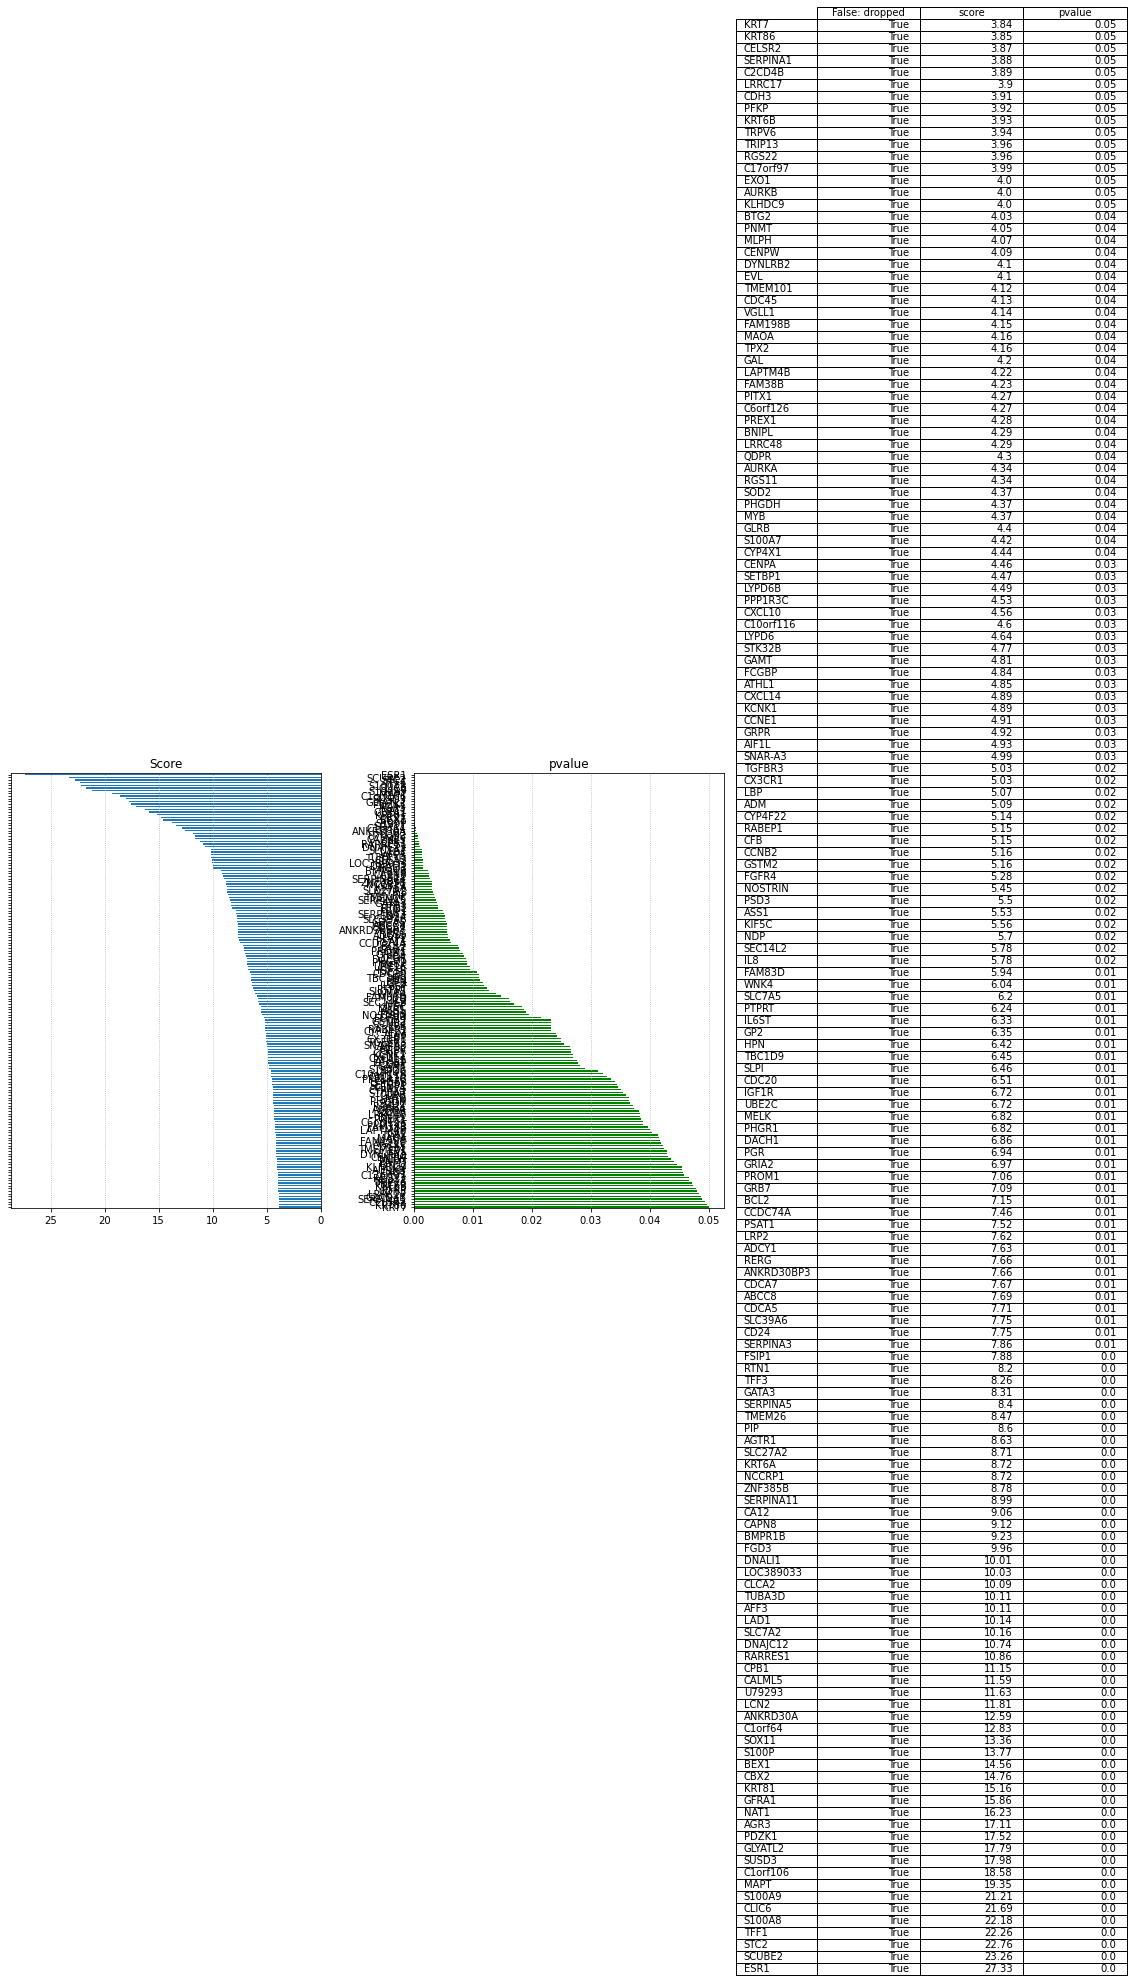

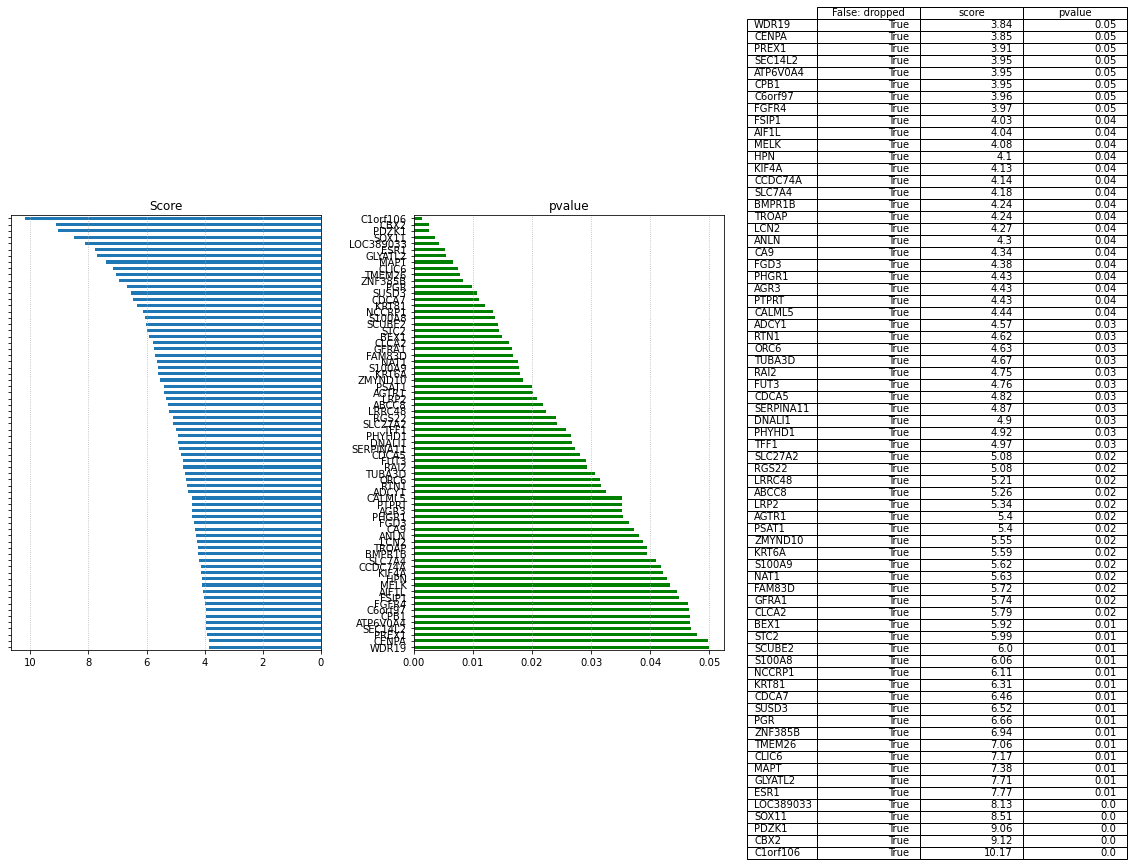

In [17]:
# 適当にプロット
plot_selection_result(result_chi2[result_chi2.pvalue < 0.05], show_p=True)
plot_selection_result(result_chi2_norm[result_chi2_norm.pvalue < 0.05], show_p=True)

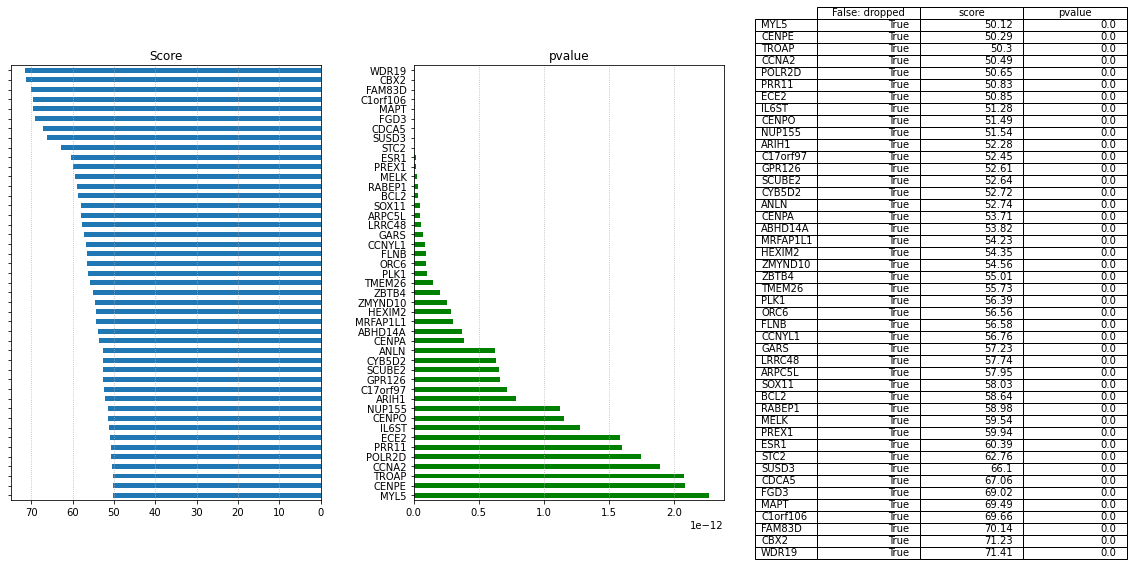

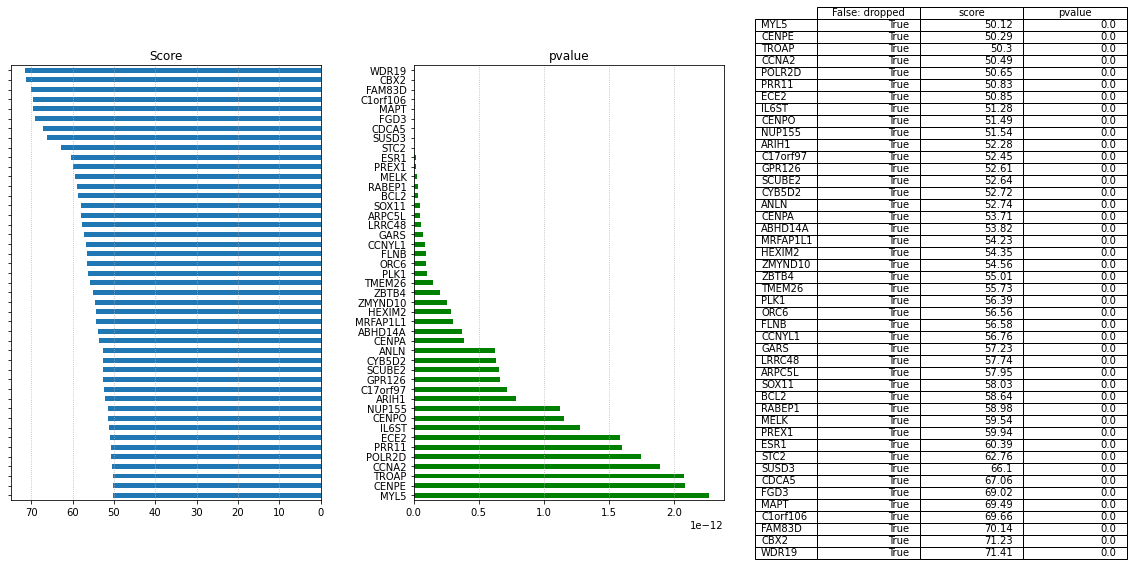

In [18]:
plot_selection_result(result_ANOVA[result_ANOVA.score > 50], show_p=True)
plot_selection_result(
    result_ANOVA_norm[result_ANOVA_norm.score > 50], show_p=True
)

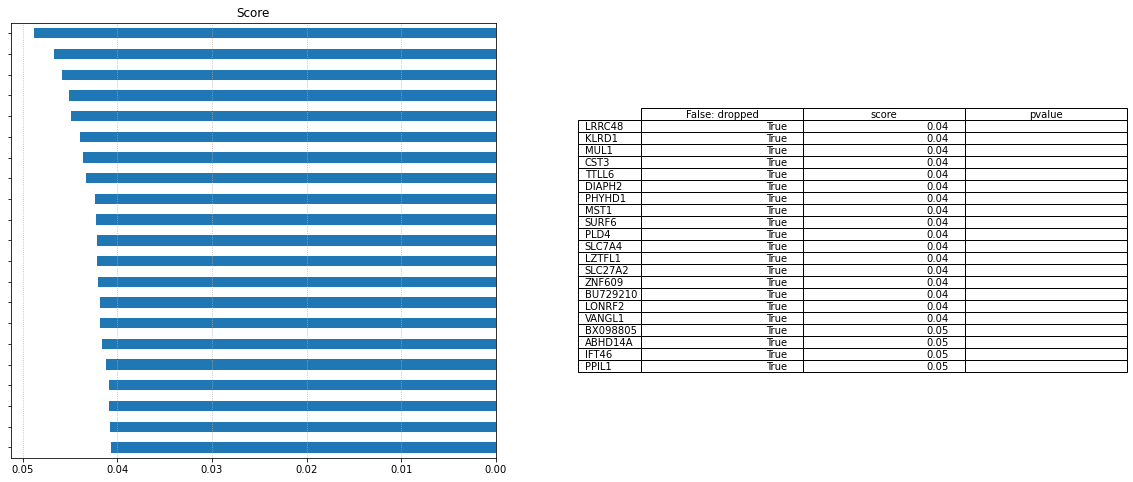

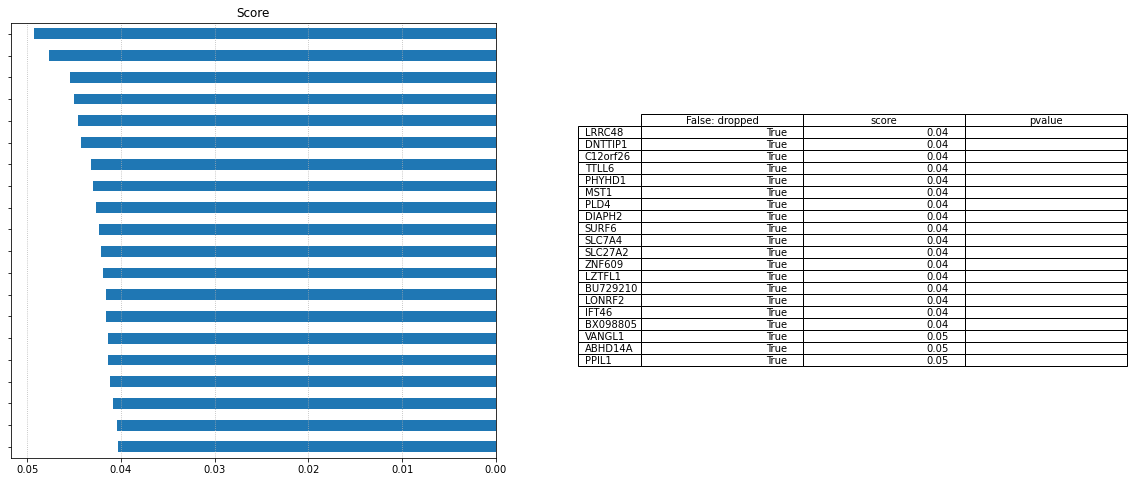

In [19]:
plot_selection_result(result_mic[result_mic.score > 0.04])
plot_selection_result(result_mic_norm[result_mic_norm.score > 0.04])

一旦保存して、予測モデルを回してみる

In [20]:
result_ANOVA[result_ANOVA.pvalue < 0.05]

,False: dropped,score,pvalue
RERE,True,17.762393,2.660956e-05
PHF7,True,43.157203,7.073533e-11
CIDEA,True,4.804115,2.855397e-02
PAPD4,True,11.603930,6.765326e-04
SDS,True,4.199520,4.061910e-02
...,...,...,...
ELANE,True,9.729150,1.850207e-03
BCAT1,True,14.046838,1.854750e-04
EGLN2,True,26.701409,2.713164e-07
VPS72,True,8.280682,4.066928e-03


In [21]:
# save
make_dir(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR)
# 特徴量抽出で選択された遺伝子と目的変数で構成されたデータフレームの作成
X_train_chi2 = X_train_norm[result_chi2[result_chi2.pvalue < 0.05].index]
X_test_chi2 = X_test_norm[result_chi2_norm[result_chi2_norm.pvalue < 0.05].index]
X_train_chi2.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_chi2.pkl"
)
X_test_chi2.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_chi2.pkl"
)

X_train_chi2_norm = X_train_norm[result_chi2_norm[result_chi2_norm.pvalue < 0.05].index]
X_test_chi2_norm = X_test_norm[result_chi2_norm[result_chi2_norm.pvalue < 0.05].index]
X_train_chi2_norm.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_chi2_norm.pkl"
)
X_test_chi2_norm.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_chi2_norm.pkl"
)

In [22]:
# 特徴量抽出で選択された遺伝子と目的変数で構成されたデータフレームの作成
X_train_ANOVA = X_train[result_ANOVA[result_ANOVA.score > 50].index]
X_test_ANOVA = X_test[result_ANOVA[result_ANOVA.score > 50].index]
# save
make_dir(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR)
X_train_ANOVA.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_ANOVA.pkl"
)
X_test_ANOVA.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_ANOVA.pkl"
)

X_train_ANOVA_norm = X_train_norm[
    result_ANOVA_norm[result_ANOVA_norm.score > 50].index
]
X_test_ANOVA_norm = X_test_norm[
    result_ANOVA_norm[result_ANOVA_norm.score > 50].index
]
# save
make_dir(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR)
X_train_ANOVA_norm.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_ANOVA_norm.pkl"
)
X_test_ANOVA_norm.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_ANOVA_norm.pkl"
)